In [23]:
import pandas as pd
import numpy as np
import os
import keras
import sys

import matplotlib.pyplot as plt
%matplotlib inline


from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Activation, Flatten
from keras.layers import Conv2D,Dense, Dropout
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import Callback, ModelCheckpoint

In [2]:
data = pd.read_csv('../input/diabetic-retinopathy-detection/trainLabels.csv')

In [3]:
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd5c84d160>]],
      dtype=object)

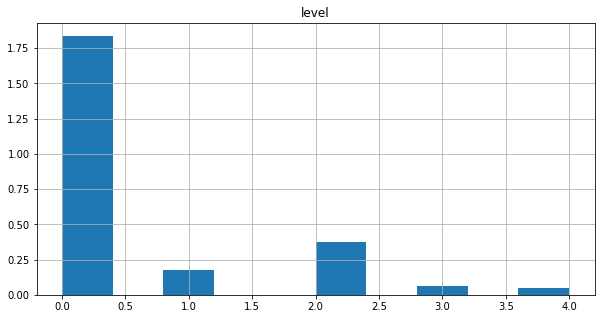

In [4]:
data[['level']].hist(figsize=(10,5),density=True)

In [5]:
data.level.value_counts(normalize=True)

0    0.734783
2    0.150658
1    0.069550
3    0.024853
4    0.020156
Name: level, dtype: float64

In [7]:
def check(x):
    tr = os.path.join('../input/train/','{}.jpeg'.format(x))
    te = os.path.join('../input/validation/','{}.jpeg'.format(x))
    if tr or te:
        return True

In [8]:
data['exist'] = data.image.map(lambda x: check(x))

In [9]:
data.head()

,image,level,exist
0,10_left,0,True
1,10_right,0,True
2,13_left,0,True
3,13_right,0,True
4,15_left,1,True


In [10]:
print('Exists', data.exist.sum(),'of',data.shape[0])

Exists 35126 of 35126


In [11]:
!jupyter --version

4.4.0


# Train/Valid split

In [26]:
for_iloc = np.arange(0,data.shape[0])
X_train, X_valid = train_test_split(for_iloc, test_size=0.1)

In [27]:
X_train = data.iloc[X_train]
X_valid = data.iloc[X_valid]

In [28]:
X_train.level.value_counts(normalize=True)

0    0.734381
2    0.151425
1    0.069623
3    0.024642
4    0.019929
Name: level, dtype: float64

In [29]:
X_valid.level.value_counts(normalize=True)

0    0.738400
2    0.143752
1    0.068887
3    0.026758
4    0.022203
Name: level, dtype: float64

In [108]:
#создадим папки под обучающую и валид выборку
!mkdir ../input/train
!mkdir ../input/validation

In [27]:
for x in X_train.values:
    froom = '../input/diabetic-retinopathy-detection/' + x[0] + '.jpeg'
    too = '../input/train/' + x[0] + '.jpeg'
    !mv $froom $too

mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/23432_left.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/13765_left.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/9237_right.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/11041_left.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/10791_right.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/4197_right.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/41215_right.jpeg': Нет такого файла или каталога
mv: не удалось выполнить stat для '../input/diabetic-retinopathy-detection/40601_right.jpeg': Нет такого файла или каталога
mv: не удалос

In [28]:
for x in X_valid.values:
    froom = '../input/diabetic-retinopathy-detection/' + x[0] + '.jpeg'
    too = '../input/validation/' + x[0] + '.jpeg'
    !mv $froom $too

In [42]:
!mkdir ../input/train/0
!mkdir ../input/train/1
!mkdir ../input/train/2
!mkdir ../input/train/3
!mkdir ../input/train/4

In [43]:
for x in X_train.values:
    if x[1] == 0:
        froom = '../input/train/' + x[0] + '.jpeg'
        too = '../input/train/0/' + x[0] + '.jpeg'
        !mv $froom $too
    elif x[1] == 1:
        froom = '../input/train/' + x[0] + '.jpeg'
        too = '../input/train/1/' + x[0] + '.jpeg'
        !mv $froom $too
    elif x[1] == 2:
        froom = '../input/train/' + x[0] + '.jpeg'
        too = '../input/train/2/' + x[0] + '.jpeg'
        !mv $froom $too
    elif x[1] == 3:
        froom = '../input/train/' + x[0] + '.jpeg'
        too = '../input/train/3/' + x[0] + '.jpeg'
        !mv $froom $too
    else:
        froom = '../input/train/' + x[0] + '.jpeg'
        too = '../input/train/4/' + x[0] + '.jpeg'
        !mv $froom $too

In [44]:
!mkdir ../input/validation/0
!mkdir ../input/validation/1
!mkdir ../input/validation/2
!mkdir ../input/validation/3
!mkdir ../input/validation/4

In [45]:
for x in X_valid.values:
    if x[1] == 0:
        froom = '../input/validation/' + x[0] + '.jpeg'
        too = '../input/validation/0/' + x[0] + '.jpeg'
        !mv $froom $too
    elif x[1] == 1:
        froom = '../input/validation/' + x[0] + '.jpeg'
        too = '../input/validation/1/' + x[0] + '.jpeg'
        !mv $froom $too
    elif x[1] == 2:
        froom = '../input/validation/' + x[0] + '.jpeg'
        too = '../input/validation/2/' + x[0] + '.jpeg'
        !mv $froom $too
    elif x[1] == 3:
        froom = '../input/validation/' + x[0] + '.jpeg'
        too = '../input/validation/3/' + x[0] + '.jpeg'
        !mv $froom $too
    else:
        froom = '../input/validation/' + x[0] + '.jpeg'
        too = '../input/validation/4/' + x[0] + '.jpeg'
        !mv $froom $too

# Data pre-processing and data augmentation

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=0.15,
    horizontal_flip=True
)

In [13]:
H,W,C = 227,227,3

In [15]:
img = Image.open('../input/train/0/100_right.jpeg')
img = img.resize((H,W)).convert('RGB')
img = np.array(img)
img = img.reshape((1,)+(H,W,C))

In [16]:
img.shape

(1, 227, 227, 3)

In [17]:
i = 0
for batch in datagen.flow(img, batch_size=1,
                          save_to_dir='../preview/', save_prefix='10_left', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

/home/bekkasik/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/bekkasik/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:996: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


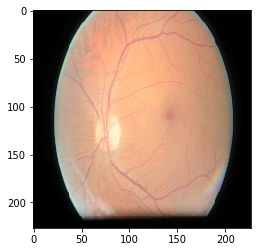

In [18]:
plt.imshow(img[0])

# AlexNet test

In [19]:
model = Sequential()

#1st Conv layer
model.add(Conv2D(filters = 96, kernel_size=(11,11), input_shape = (227,227,3), strides=(4,4),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

#2nd Conv layer
model.add(Conv2D(filters=256, kernel_size=(11,11),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

#3rd Conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))

#4th Conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))

#5th Conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

#FC
model.add(Flatten())
#1st FC
model.add(Dense(4096,input_shape=(227*227*3,)))
model.add(Activation('relu'))
model.add(Dropout(0,4))

# 2nd FC
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))

# 3rd FC
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)         885120    
__________

In [20]:
opt = SGD(lr=0.0005)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy']) 

# Сбросились разделения, загружаем данные иначе

### Let's prepare our data

In [21]:
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 15,
    width_shift_range = 0.15,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../input/train/',
    target_size=(H,W), 
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    '../input/validation/',
    target_size=(H,W), 
    batch_size=batch_size,
    class_mode='categorical'    
)

Found 31613 images belonging to 5 classes.
Found 3513 images belonging to 5 classes.


In [24]:
checkpointer = ModelCheckpoint(monitor='val_acc',filepath='../Model/KerasVGG16BestWeights.hpf5', verbose=1, save_best_only=True)

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch = 31_613//batch_size,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 3_513//batch_size,
    callbacks = [checkpointer]    
)
model.save_weights('AlexNetFT.h5')

Epoch 1/15
1390/1975 [====================>.........] - ETA: 18:45 - loss: 1.1609 - acc: 0.7323